In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm_notebook as tqdm
import networkx as nx
import pywt
from scipy.fftpack import fft, rfft
from pymssa import MSSA


matplotlib.rcParams.update(
    {
        'text.usetex': False,
        'font.family': 'stixgeneral',
        'mathtext.fontset': 'stix',
    }
)
sns.set(font_scale=2)
sns.set_style("whitegrid")
sns.set_context("talk")

/root/miniconda/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


## Data loading

In [2]:
chaos = pd.read_csv('./chaos_sample_5.txt', delimiter='\t')
timestamps = np.array(chaos.index)

In [3]:
chaos.head()

,5001,5002,5003,5004,5005,5006,5007,5008,5009,5010,...,5356,5357,5358,5359,5360,5361,5362,5363,5364,5365
90000.0,-0.000018,-0.001784,-0.917791,4.408553,-0.421157,-0.001683,-0.001692,-35.029201,-0.898255,2.201222,...,-0.000024,-0.000349,-0.000304,-0.000090,-0.000115,-0.000312,-0.000345,-0.000689,-0.000311,-0.000064
90018.0,0.000027,-1.190258,-0.914819,5.881844,-2.097727,-4.178118,-5.418659,-48.139564,-4.477319,1.323359,...,0.000036,0.000515,0.000449,0.000133,0.000170,0.000461,0.000509,0.001016,0.000459,0.000095
90036.0,-0.000092,1.184401,0.910830,7.343917,-0.005728,-1.401305,-2.040379,-52.529410,-1.801491,2.196292,...,-0.000123,-0.001773,-0.001544,-0.000458,-0.000586,-0.001587,-0.001750,-0.003498,-0.001578,-0.000327
90054.0,-0.000174,1.176377,4.573808,7.338222,-0.011130,3.472234,2.699381,-26.249873,-3.602408,5.275150,...,-0.000232,-0.003344,-0.002912,-0.000864,-0.001105,-0.002992,-0.003300,-0.006596,-0.002976,-0.000617
90074.0,-0.000287,1.165260,7.318367,8.800920,2.081696,6.251727,3.367077,-26.268146,-0.029089,8.352831,...,-0.000383,-0.005520,-0.004807,-0.001426,-0.001825,-0.004939,-0.005448,-0.010888,-0.004913,-0.001019


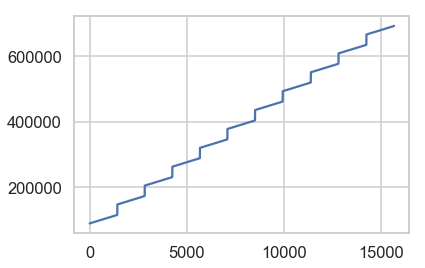

In [4]:
plt.plot(timestamps)

## Preprocessing

  1. Divide samples according to 
  2. Resample it with 18 sec intervals
  3. Smoothing with `savgol_filter`(not interested in high frequencies __for now__)

In [5]:
from scipy.signal import savgol_filter
from scipy import interpolate

In [6]:
X_divided = []
timestamps_divided = []

t_prev = 0
argdiff = np.argwhere(np.diff(timestamps) > 100).ravel()
for t_next in argdiff[:-1][np.diff(argdiff) > 100]:
    if t_next - t_prev < 20:
        t_prev = t_next
        continue
    print(t_next - t_prev)
    X_selected = chaos.values[t_prev + 1:t_next, :]
    timestamps_selected = timestamps[t_prev + 1: t_next]
    f = interpolate.interp1d(timestamps_selected, X_selected, axis=0)
    ts_resampled = np.arange(timestamps_selected.min(), timestamps_selected.max(), 18.)
    X_resampled = f(ts_resampled)
    timestamps_divided.append(ts_resampled)
    X_divided.append(savgol_filter(X_resampled, window_length=21, polyorder=3, axis=0))
    t_prev = t_next

/root/miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater
  """


1421
1410
1421
1422
1415
1422
1425
1447
1425
1435


Check that everything is OK

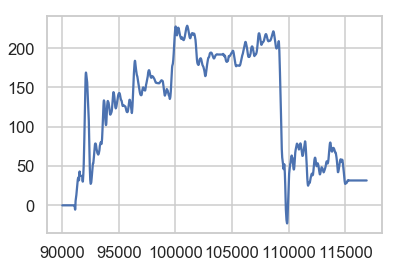

In [7]:
plt.plot(timestamps_divided[0], X_divided[0][:, 0])

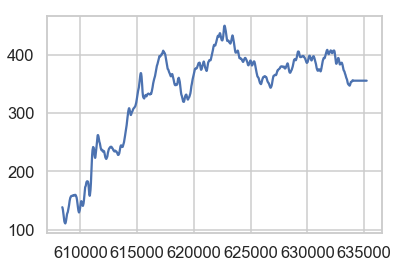

In [8]:
plt.plot(timestamps_divided[-1], X_divided[-1][:, 12])

## MSSA

https://arxiv.org/pdf/1308.4022.pdf

https://github.com/kieferk/pymssa

In [9]:
d = 0
X = X_divided[d]
timestamps = timestamps_divided[d]

In [10]:
X.shape

(1493, 365)

In [11]:
def std_norm(x: np.ndarray, axis=-1):
    return (x - x.mean(axis=axis, keepdims=True)) / x.std(axis=axis, keepdims=True)

In [12]:
%%time
mssa = MSSA(window_size=200, n_components=50).fit(std_norm(X[:, :30], axis=0))

Constructing trajectory matrix
Trajectory matrix shape: (6000, 1294)
Decomposing trajectory covariance matrix with SVD
Constructing components
Calculating optimal reconstruction orders
CPU times: user 5min 32s, sys: 5min 22s, total: 10min 55s
Wall time: 50.7 s


### Выбираем пары тайм серий с скоррелированным компонентами взвешенными с долей объяснённой дисперсии.

In [13]:
def normalized_correlation(x, y):
    x = std_norm(x) / len(x)
    y = std_norm(y)
    return np.abs(np.correlate(x, y, mode='same')).max()


def explained_var_two_series(i: int, j: int, mssa: MSSA, k: int):
    """
    Calculating explained variance with k first common components. 
    Takes into account correlation between components 
    because they are not fully orthogonal by construction.
    i -- first time seria
    j -- second time seria 
    k -- number of components to look at
    
    """
    component_ranks = mssa.component_ranks_[:k, [i, j]]
    component_ranks_explained_variance = mssa.component_ranks_explained_variance_[:k, [i, j]]

    common_components = set(component_ranks[:, 0].tolist()) & set(component_ranks[:, 1].tolist())

    explained_total_1 = {}
    for rank, explained_var in zip(component_ranks[:, 0], component_ranks_explained_variance[:, 0]):
        if rank in common_components:
            explained_total_1[rank] = explained_var

    explained_total_2 = {}
    for rank, explained_var in zip(component_ranks[:, 1], component_ranks_explained_variance[:, 1]):
        if rank in common_components:
            explained_total_2[rank] = explained_var
            
    explained_total = {}
    for rank in common_components:
        explained_total[rank] = normalized_correlation(mssa.components_[i, :, rank], mssa.components_[j, :, rank]) * min(explained_total_1[rank], explained_total_2[rank])
        # np.abs(np.corrcoef(mssa.components_[i, :, rank], mssa.components_[j, :, rank])[0, 1]) * min(explained_total_1[rank], explained_total_2[rank])
        # normalized_correlation
    return sum(explained_total.values())

explained_var_two_series(5, 24, mssa, 10)

0.8247129595719564

#### Трешхолдим все возможные пары временных рядов

In [14]:
threshold_explained_variance = 0.8

In [15]:
%%time
explained_vars = []
pairs = []
for i in np.arange(30):
    for j in np.arange(i):
        expl = explained_var_two_series(i, j, mssa, k=5)
        if expl > threshold_explained_variance:
            explained_vars.append(expl)
            pairs.append((i, j))

CPU times: user 500 ms, sys: 0 ns, total: 500 ms
Wall time: 495 ms


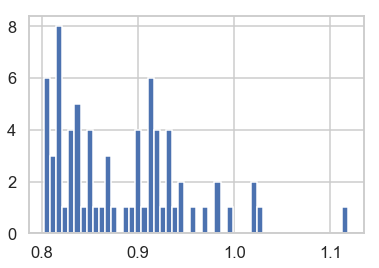

In [16]:
plt.hist(explained_vars, bins=50);

In [17]:
len(pairs)

72

### Посмотрим на несколько отобранных пар

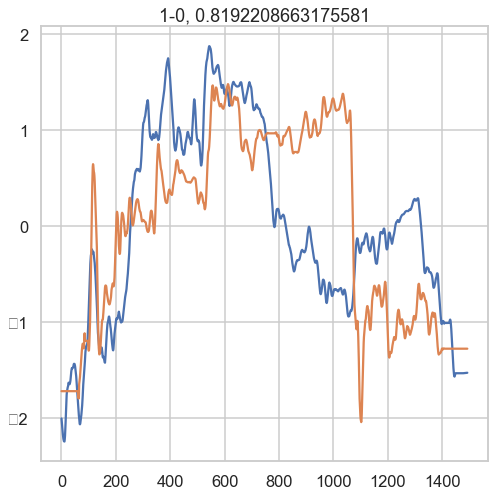

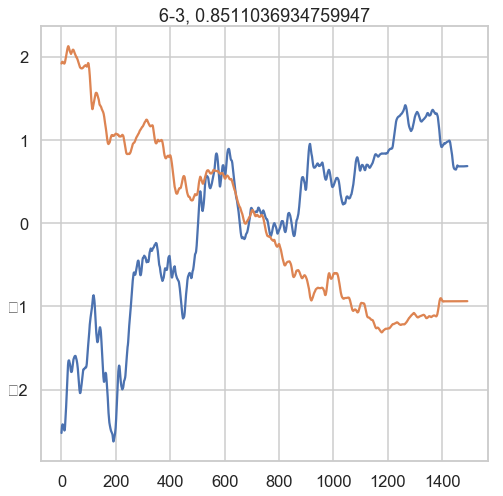

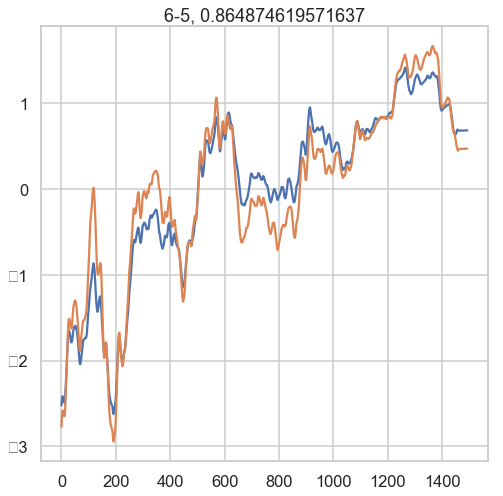

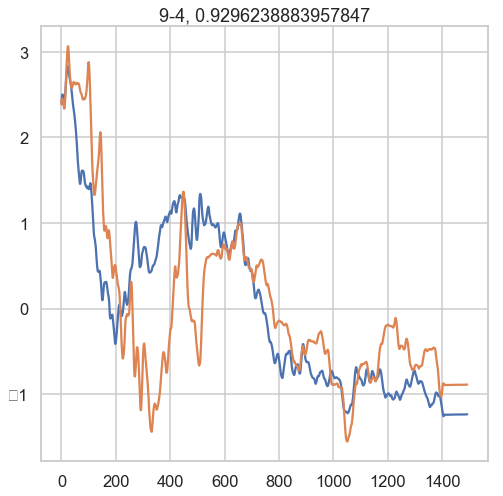

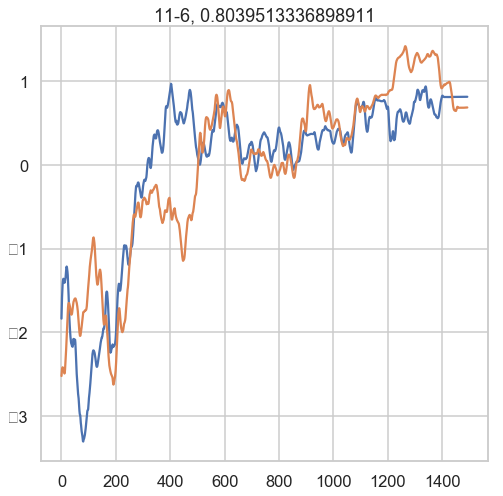

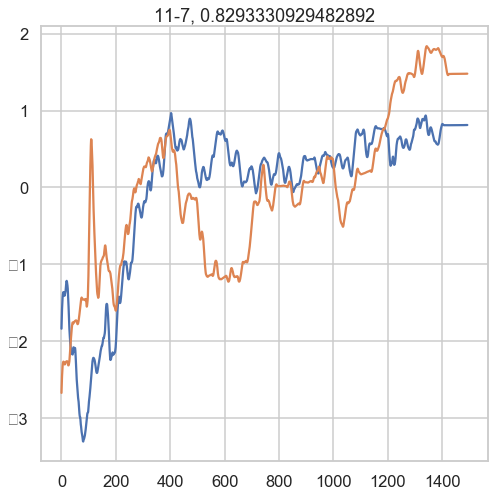

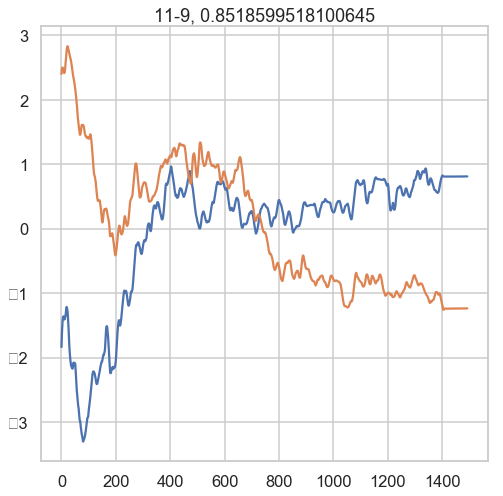

In [18]:
for enum, (i, j) in enumerate(pairs[:7]):
    plt.figure(figsize=(8, 8))
    plt.title('{}-{}, {}'.format(i, j, explained_vars[enum]))
    plt.plot(std_norm(X[:, i]))
    plt.plot(std_norm(X[:, j]))
    plt.show()

### Ищем аномалии

In [19]:
from scipy.stats import pearsonr
from scipy.signal import welch, coherence
from scipy.spatial.distance import cosine
from scipy.stats import energy_distance
from scipy.signal import resample


def power_spectrum_distance(x: np.ndarray, y: np.ndarray):
    return coherence(x, y, nperseg=len(x) // 6)[1].mean()

def wavelet_spectrum_distance(x: np.ndarray, y: np.ndarray, wavelet: str='db2'):
    (cAx, cDx) = pywt.dwt(x, wavelet)
    (cAy, cDy) = pywt.dwt(y, wavelet)
    return 1 - cosine(cAx, cAy)

def mse(x, y):
    return np.sqrt((np.square(x - y)).mean())

def std_norm(x, axis=-1):
    return (x - x.mean(axis=axis, keepdims=True)) / x.std(axis=axis, keepdims=True)

def construct_rolling_distances(x, y, distance_metric, window=10, step=5):
    assert len(x) == len(y)
    if len(x) < window:
        return None
    distance_matrix = []
    offset = 0
    while offset < len(x):
        distance_matrix.append(distance_metric(x[offset: offset + window], 
                                               y[offset: offset + window]))
        offset += step
    return np.array(distance_matrix)

def reconstruct_timeseria(ts, mssa, i, k=3):
    reconstructed = mssa.components_[i][:, mssa.component_ranks_[:, i][:k]].sum(axis=1)
    return reconstructed * ts.std() + ts.mean()

In [20]:
# i, j, k = 13, 0, 10
i, j, k = 14, 16, 10

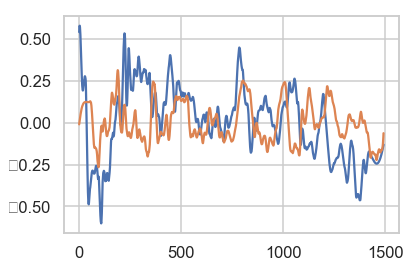

In [21]:
plt.plot(std_norm(reconstruct_timeseria(ts=X[:, i], mssa=mssa, i=i, k=k)) - std_norm(X[:, i]));
plt.plot(std_norm(reconstruct_timeseria(ts=X[:, j], mssa=mssa, i=j, k=k)) - std_norm(X[:, j]));

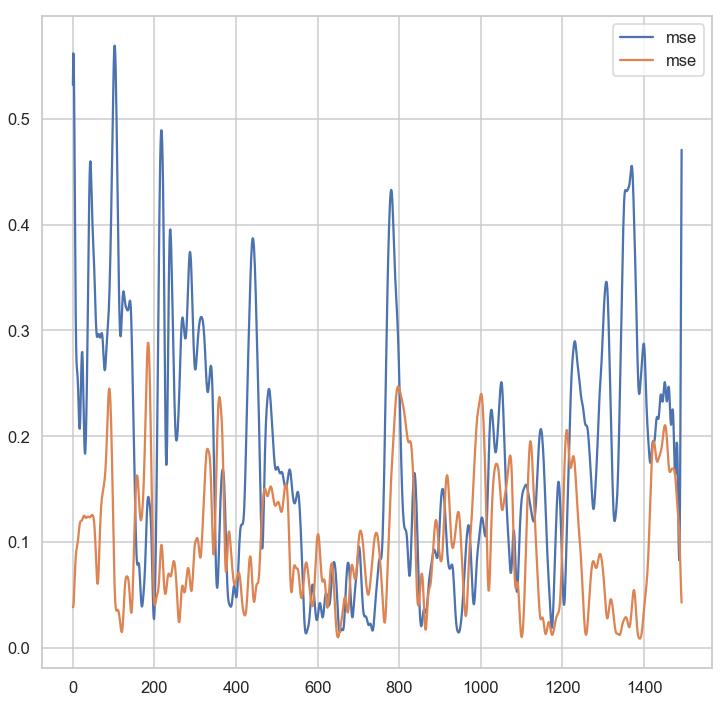

In [22]:
step=5
window=10

plt.figure(figsize=(12, 12))
plt.plot(resample(construct_rolling_distances(std_norm(X[:, i]), 
                                              std_norm(reconstruct_timeseria(ts=X[:, i], mssa=mssa, i=i, k=k)), 
                                              mse, 
                                              window=window, step=step), len(X)), label='mse')
plt.plot(resample(construct_rolling_distances(std_norm(X[:, j]), 
                                     std_norm(reconstruct_timeseria(ts=X[:, j], mssa=mssa, i=j, k=k)), 
                                     mse, 
                                     window=window, step=step), len(X)), label='mse')
plt.legend()
plt.show()

### SSA для поиска разладки

In [23]:
# taken from https://github.com/tsurubee/banpei/blob/183e7ec0b0d9de23dbeb01cbd357ea55d26c66ff/banpei/sst.py
# adapted to multivariate data

from scipy.linalg import hankel
def _extract_matrix(data, start, end, w):
    row = w
    column = end - start + 1
    matrix = np.empty((row, column))
    i = 0
    for t in range(start, end+1):
        matrix[:, i] = data[t-1:t-1+row]
        i += 1
    return matrix

def ts_matrix_to_trajectory_matrix(timeseries, start, end, w):
    '''
    https://www.researchgate.net/publication/263870252_Multivariate_singular_spectrum_analysis_A_general_view_and_new_vector_forecasting_approach
    '''
    N, P = timeseries.shape

    trajectory_matrix = [
        _extract_matrix(timeseries[:, p], start, end, w)
        for p in range(P)
    ]

    trajectory_matrix = np.concatenate(trajectory_matrix, axis=0)
    return trajectory_matrix

class SST:
    def __init__(self, w, m=2, k=None, L=None):
        """
        Parameters
        ----------
        w    : int
               Window size
        m    : int
               Number of basis vectors
        k    : int
               Number of columns for the trajectory and test matrices
        L    : int
               Lag time
        """
        self.w = w
        self.m = m
        if k is None:
            self.k = self.w // 2
        else:
            self.k = k
        if L is None:
            self.L = self.k // 2
        else:
            self.L = L

    def detect(self, data, is_lanczos=False):
        """
        Batch mode detection
        Parameters
        ----------
        data : array_like
               Input array or object that can be converted to an array.
        is_lanczos : boolean
               If true, the change score is calculated based on the lanczos method
        Returns
        -------
            Numpy array contains the degree of change.
            The size of Numpy array is the same as input array.
        """
        # Set variables
        T = len(data)

        # Check the size of input data
        if not len(data) > self.L + self.w + self.k - 2:
            raise ValueError("Input data is too small.")

        # Calculation range
        start_cal = self.k + self.w
        end_cal = T - self.L + 1

        # Calculate the degree of change
        change_scores = np.zeros(len(data))
        for t in range(start_cal, end_cal + 1):
            # Trajectory matrix
            start_tra = t - self.w - self.k + 1
            end_tra = t - self.w
            tra_matrix = ts_matrix_to_trajectory_matrix(data, start_tra, end_tra, self.w)

            # Test matrix
            start_test = start_tra + self.L
            end_test = end_tra + self.L
            test_matrix = ts_matrix_to_trajectory_matrix(data, start_test, end_test, self.w)

            # Calculate the score by singular value decomposition(SVD)
            if is_lanczos:
                change_scores[t] = self._calculate_score_by_lanczos(tra_matrix, test_matrix)
            else:
                change_scores[t] = self._calculate_score_by_svd(tra_matrix, test_matrix)

        return change_scores

    def _calculate_score_by_svd(self, tra_matrix, test_matrix):
        U_tra, _, _ = np.linalg.svd(tra_matrix, full_matrices=False)
        U_test, _, _ = np.linalg.svd(test_matrix, full_matrices=False)
        U_tra_m = U_tra[:, :self.m]
        U_test_m = U_test[:, :self.m]
        s = np.linalg.svd(np.dot(U_tra_m.T, U_test_m), full_matrices=False, compute_uv=False)
        return 1 - s[0]

    def _extract_matrix(self, data, start, end, w):
        row = w
        column = end - start + 1
        matrix = np.empty((row, column))
        i = 0
        for t in range(start, end+1):
            matrix[:, i] = data[t-1:t-1+row]
            i += 1

        return matrix
    
# TODO

TODO

1. `_extract_matrix` краевые эффекты + 
2. комбинировать аномалии от разных тайм серий + 
3. ???(ICA??)

In [24]:
# i, j, k = 14, 16, 10
i, j, k = 13, 0, 10

In [25]:
len(X) // 2 - 1

745

In [ ]:
%%time
sst = SST(w=300, m=2)
results1 = sst.detect(std_norm(np.c_[X[:, i], X[:, j]], axis=0)) * 1e3
results2 = sst.detect(std_norm(np.c_[X[:, i][::-1], X[:, j][::-1]], axis=0))[::-1] * 1e3

In [ ]:
(results1 * results2).max()

In [ ]:
diff = results1 * results2

In [ ]:
plt.figure(figsize=(12, 12))

plt.plot(std_norm(X[:, i]), label='time seria 1', alpha=0.5)
plt.plot(std_norm(X[:, j]), label='time seria 2', alpha=0.5)

plt.twinx()
plt.plot(diff, c='g', label='residuals')
plt.legend()
plt.show()

### Breakout

https://eric-bunch.github.io/blog/breakout-detection-by-twitter

In [ ]:
plt.figure(figsize=(12, 12))

plt.plot(std_norm(X[:, i]), label='time seria 1', alpha=0.5)
plt.plot(std_norm(X[:, j]), label='time seria 2', alpha=0.5)

plt.twinx()
plt.plot(diff, c='g', label='residuals')
plt.legend()
plt.show()

In [ ]:
# TODO: breakout detection of 
# https://eric-bunch.github.io/blog/breakout-detection-by-twitter
import breakout_detection
edm_multi = breakout_detection.EdmMulti() 
edm_multi.evaluate(diff, min_size=10, beta=1e-7, degree=1) 

In [ ]:
plt.figure(figsize=(12, 12))

plt.plot(std_norm(X[:, i]), label='time seria 1')
plt.plot(std_norm(X[:, j]), label='time seria 2')
for t in edm_multi.getLoc(): 
    plt.axvline(t, color='#FF4E24')
plt.twinx()
plt.plot(diff, c='g', label='residuals')
plt.legend()
plt.show()

## Bitmap

http://alumni.cs.ucr.edu/~ratana/SSDBM05.pdf

https://github.com/linkedin/luminol

In [ ]:
def prepare_data_to_luminol(ts: np.ndarray):
    return {key: value for key, value in enumerate(ts)}

In [ ]:
import luminol
from luminol import anomaly_detector
detector = luminol.anomaly_detector.AnomalyDetector(prepare_data_to_luminol(diff))
anomalies = detector.get_anomalies()

In [ ]:
plt.figure(figsize=(12, 12))

plt.plot(std_norm(X[:, i]))
plt.plot(std_norm(X[:, j]))
for t in [np.mean(anomaly.get_time_window()) for anomaly in anomalies]: 
    plt.axvline(t, color='#FF4E24')
plt.twinx()
plt.plot(diff, c='g', label='residuals')
plt.legend()
plt.show()

### Игрушечный пример для наблюдения интересующих нас эффектов

In [ ]:
from scipy import signal
import matplotlib.pyplot as plt
t = np.linspace(0, 1, 500, endpoint=False)
sig1 = signal.square(2 * np.pi * 5 * t) + t
sig2 = signal.square(2 * np.pi * 5 * t + 5)
sig2[250:] = np.roll(sig2[250:], 20)
plt.plot(sig1)
plt.plot(sig2)

#### Посмотрим на скор аномалии для прямого прогона алгоритма

In [ ]:
sst = SST(w=100, m=5, L=20)
results1 = sst.detect(np.c_[sig1, sig2])
plt.plot(results1)

##### ... для обратного прогона

In [ ]:
sst = SST(w=100, m=5, L=20)
results2 = sst.detect(np.c_[sig1[::-1], sig2[::-1]])
plt.plot(results2[::-1])

#### Визуализация временных рядов и перемноженного скора аномалий

In [ ]:
plt.figure(figsize=(12, 12))
plt.plot(sig1)
plt.plot(sig2)
plt.twinx()
plt.plot(results1 * results2[::-1], c='g')
plt.show()

### А теперь посмотрим на собственные компоненты этой пары временных рядов

In [ ]:
%%time
mssa_testing = MSSA(window_size=200).fit(std_norm(np.c_[sig1, sig2], axis=0))

In [ ]:
plt.figure(figsize=(12, 12))
for i in range(10):
    plt.plot(mssa_testing.components_[0][:, i], label='comp {}'.format(i))
plt.plot(sig1, label='original time seria')
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(12, 12))
for i in range(3):
    plt.plot(mssa_testing.components_[1][:, i], label='comp {}'.format(i))
plt.plot(sig2, label='original time seria')
plt.legend()
plt.show()

### Тонкий момент

Как видно из примера выше для первого временного ряда нет трендовой компоненты.

Это известная особенность SSA связанная с нормализацией данных.

https://dept.atmos.ucla.edu/sites/default/files/MSSA-PS-PRE_vf.pdf

In [ ]:
%%time
mssa_testing = MSSA(window_size=200).fit(np.c_[sig1, sig2])

In [ ]:
plt.figure(figsize=(12, 12))
for i in range(10):
    plt.plot(mssa_testing.components_[0][:, i], label='comp {}'.format(i))
plt.plot(sig1, label='original time seria')
plt.legend()
plt.show()

#### Почему нужна кросс-корреляция

In [ ]:
plt.plot(mssa_testing.components_[0][:, 0])
plt.plot(mssa_testing.components_[1][:, 0])
normalized_correlation(mssa_testing.components_[0][:, 0], mssa_testing.components_[1][:, 0])